# TP3 : Clustering et word2vec

## Imports et configuration

In [ ]:
# Imports

import collections
import os
import string
import sys

import nltk
import pandas as pd

nltk.download('punkt')
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from unidecode import unidecode

# Config

data_path = "../data/txt/"

## Première partie : Clustering de documents

### Charger tous les  fichiers de la décennie et en créer une liste de textes

In [95]:
DECADE = '1930'

files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

# Vérifier si c'est bien 1930: OK
print(files[:5])

texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

# Pour voir à quoi ressemble le premier document: tout est OK
print(texts[0][:400])

['KB_JB838_1930-01-05_01-00006.txt', 'KB_JB838_1930-01-09_01-00001.txt', 'KB_JB838_1930-01-09_01-00014.txt', 'KB_JB838_1930-01-16_01-00010.txt', 'KB_JB838_1930-01-20_01-00002.txt']
15 G I C 3. L ^ SQ| R V .1- . FINANCE - INDUSTRIE - COMMERCE BOURSE de BRUXELLES I Marchés d’Anvers REVUE HEBDOMADAIRE La Eourse, qui avait très peu de chance de g.tg:v»r en aciivi.é penciant cette semaine raccourcie par le congé du Nouvel- Aii, a c i cependant une attitude qui permet de bien augurer des prochaines séances. L's capitalistes semblent enfin s’être rendu compte cours leur fou: quelqu


### Vectoriser les documents à l'aide de TF-IDF

In [96]:
# Création d'une fonction de pré-traitement

def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

# Instancier le modèle TF-IDF avec ses arguments

vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5, #ignorer les mots apparaissant dans plus de 50% des docs
    min_df=0.1, #ignorer les mots apparaissant dans moins de 10% des docs
    lowercase=True #tout mettre en minuscules
)

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

tfidf_vectors = vectorizer.fit_transform(texts)

In [97]:
# Imprimer les détails de la matrice

tfidf_vectors

<1000x3941 sparse matrix of type '<class 'numpy.float64'>'
	with 789289 stored elements in Compressed Sparse Row format>

### Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

In [139]:
# Nbre clusters

N_CLUSTERS = 4

# Instancier le modèle K-Means et ses arguments

km_model = KMeans(n_clusters=N_CLUSTERS)

# Appliquer le clustering à l'aide de la fonction fit_predict

clusters = km_model.fit_predict(tfidf_vectors)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [141]:
# Afficher le résultat du clustering (un dictionnaire)

pprint(dict(clustering))

{0: ['KB_JB838_1930-01-05_01-00006.txt',
     'KB_JB838_1930-01-09_01-00001.txt',
     'KB_JB838_1930-01-20_01-00002.txt',
     'KB_JB838_1930-01-30_01-00006.txt',
     'KB_JB838_1930-02-05_01-00005.txt',
     'KB_JB838_1930-03-01_01-00004.txt',
     'KB_JB838_1930-03-13_01-00003.txt',
     'KB_JB838_1930-03-21_01-00004.txt',
     'KB_JB838_1930-04-03_01-00004.txt',
     'KB_JB838_1930-04-06_01-00007.txt',
     'KB_JB838_1930-04-07_01-00003.txt',
     'KB_JB838_1930-04-14_01-00006.txt',
     'KB_JB838_1930-04-16_01-00016.txt',
     'KB_JB838_1930-05-06_01-00008.txt',
     'KB_JB838_1930-05-18_01-00011.txt',
     'KB_JB838_1930-06-16_01-00004.txt',
     'KB_JB838_1930-06-24_01-00004.txt',
     'KB_JB838_1930-07-25_01-00005.txt',
     'KB_JB838_1930-07-26_01-00006.txt',
     'KB_JB838_1930-08-05_01-00004.txt',
     'KB_JB838_1930-08-11_01-00003.txt',
     'KB_JB838_1930-08-17_01-00004.txt',
     'KB_JB838_1930-08-19_01-00003.txt',
     'KB_JB838_1930-08-20_01-00002.txt',
     'KB_JB838_1

### Visualiser les clusters

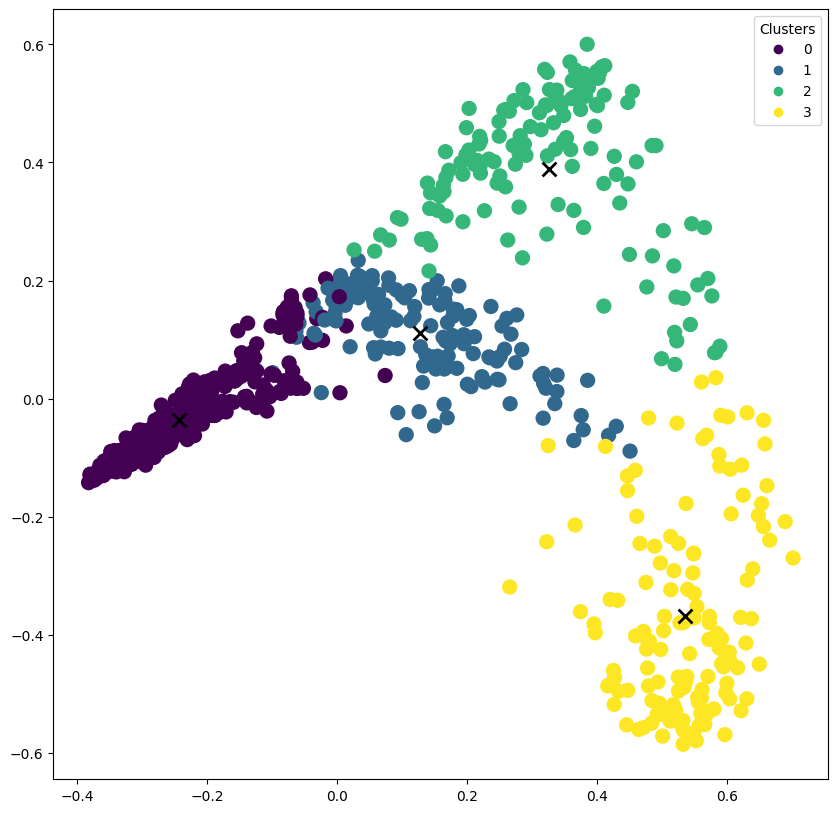

In [140]:
# Réduire les vecteurs à 2 dimensions

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

# Générer le graphe

x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

## Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

## Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

## Deuxième partie : Word2vec

### Chargement et traitement des phrases du corpus

In [ ]:
# Création d'un objet qui streame les lignes d'un fichier pour économiser de la RAM

class MySentences(object):
    """Tokenize and Lemmatize sentences""" #permet de tokenizer des "doubles" mots, par ex "premier" + "ministre" va être considéré comme un token "premier ministre"
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

infile = f"../data/sents.txt"
sentences = MySentences(infile)

#### Détection des bigrams

In [ ]:
# Création de l'objet 'phrases' = "dictionnaire d'expressions multi-mots associées à un score", dont les clés correspondent aux termes du corpus

bigram_phrases = Phrases(sentences)

In [ ]:
# Conversion des objets 'phrases' en objet 'phraser' = version light du 'phrases' -> convertit certains unigrams en bigrams s'ils sont pertinents

bigram_phraser = Phraser(phrases_model=bigram_phrases)

#### Détection des trigrams

In [ ]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [ ]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

#### Créations d'un corpus d'unigrams, bigrams, trigrams

In [ ]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

print(corpus[:100])

#imprime une liste de n-grammes, qu'on répère car ils sont séparés par des _

### Entraînement d'un modèle word2vec sur ce corpus

In [ ]:
%%time
model = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=5, # On ignore les mots qui n'apparaissent pas au moins 5 fois dans le corpus
    workers=3, # Permet de paralléliser l'entraînement du modèle en 4 threads -> si la machine est sur le point d'exploser, diminuer
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descente de gradient, aka. epochs.

# pour tester: petite fenêtre de mots, peu de workers, haut min_count, peu d'epoch -> puis améliorer itérativement le modèle

)

# Sauver le modèle dans un fichier
outfile = f"../data/newspapers.model"
model.save(outfile)

### Exploration du modèle

In [ ]:
# Charger le modèle en mémoire

model = Word2Vec.load("../data/newspapers.model")

In [ ]:
# Imprimer le vecteur d'un terme

model.wv["ministre"] #si erreur, vérifier si le mot apparaît bien dans la sélection (surtout si on garde juste des mots très fréquents)

In [ ]:
# Calculer la similarité entre deux termes

model.wv.similarity("ministre", "roi")

In [ ]:
# Chercher les mots les plus proches d'un terme donné

model.wv.most_similar("ministre", topn=10)

In [ ]:
# Faire des recherches complexes à travers l'espace vectoriel

print(model.wv.most_similar(positive=['paris', 'londres'], negative=['belgique'])) #positive = proche, negative=éloigné